## Data UnderStanding

- id - a unique identifier for each trip

- vendor_id - a code indicating the provider associated with the trip record

- pickup_datetime - date and time when the meter was engaged

- dropoff_datetime - date and time when the meter was disengaged

- passenger_count - the number of passengers in the vehicle (driver entered value)

- pickup_longitude - the longitude where the meter was engaged

- pickup_latitude - the latitude where the meter was engaged

- dropoff_longitude - the longitude where the meter was disengaged

- dropoff_latitude - the latitude where the meter was disengaged

- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle 
  memory before sending to the vendor because the vehicle did not have a connection 
  to the server – Y=store and forward; N=not a store and forward trip

- trip_duration - duration of the trip in seconds


## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import warnings
import os
warnings.filterwarnings("ignore")

## Get Data

In [2]:
train_dir = r'E:\ML\projects\1 project-nyc-taxi-trip-duration\split'
val_dir = r'E:\ML\projects\1 project-nyc-taxi-trip-duration\split'
df_train = pd.read_csv(os.path.join(train_dir,'train.csv'))
df_val = pd.read_csv(os.path.join(val_dir,'val.csv'))

## Data Exploration

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


In [4]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229319 entries, 0 to 229318
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  229319 non-null  object 
 1   vendor_id           229319 non-null  int64  
 2   pickup_datetime     229319 non-null  object 
 3   passenger_count     229319 non-null  int64  
 4   pickup_longitude    229319 non-null  float64
 5   pickup_latitude     229319 non-null  float64
 6   dropoff_longitude   229319 non-null  float64
 7   dropoff_latitude    229319 non-null  float64
 8   store_and_fwd_flag  229319 non-null  object 
 9   trip_duration       229319 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 17.5+ MB


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


In [6]:
print(df_train.store_and_fwd_flag.value_counts())
print(df_train.vendor_id.value_counts())

store_and_fwd_flag
N    994443
Y      5557
Name: count, dtype: int64
vendor_id
2    534793
1    465207
Name: count, dtype: int64


vendor_id has two classes 1 and 2 , represent the vechicle provider 

passenger_count has minimum zero! and maximum 7!,but minimum passengers should be 1 and maximum passengers should be six(maybe it depends on taxi provider)
<pre>
For NYC
Latitude:
Minimum: 40.49° N
Maximum: 40.92° N
Longitude:
Minimum: -74.27° W
Maximum: -73.68° W
but we have minimum pickup_lat = 34.359695 and maximum pickup_lat = 51.88108 , minimum pickup_lang = 121.933342 and maximum pickup_lang=-61.33553
</pre>
trip_duration(target feature):has minimum 1 second and maximum 618.78 hours which represent very high outliers
trip_duration has average 662.000000 seconds which represent 11 minute

store_and_fwd_flag has two values N indicate the data was sent to the server in real-time, Y represent it was stored in vechicle memory and sent later when connection back


In [7]:
df_train.duplicated().sum()

np.int64(0)

## EDA

## Target Feature

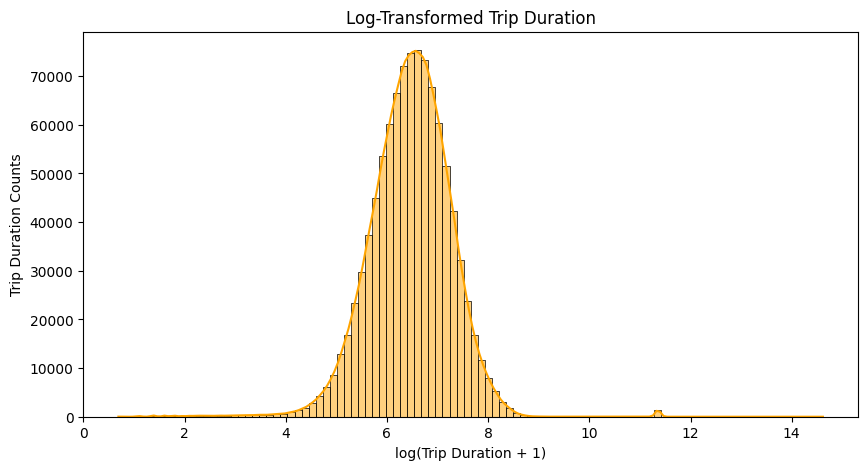

In [8]:
# we will apply log1p to trip duration to dominate the right skweness
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df_train['trip_duration']), bins=100, kde=True, color='orange')
plt.title('Log-Transformed Trip Duration')
plt.xlabel('log(Trip Duration + 1)')
plt.ylabel('Trip Duration Counts')
plt.show()

most of data exist in range from 5 to 7 which equal to 2.5 minutes to 18.26 minutes

we see high skewed data from left and right (outliers)

### Explore Pickup DateTime

In [9]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

In [10]:
print(f'statring date : {min(df_train['pickup_datetime'] )} and last date : {max(df_train['pickup_datetime'] )}')
date_range = (df_train['pickup_datetime'].max() - df_train['pickup_datetime'].min()).days + 1
print(f"The date range: {date_range} days")

statring date : 2016-01-01 00:00:53 and last date : 2016-06-30 23:59:37
The date range: 182 days


our data is in year 2016 , has range 6 months from 1 to 6 (182 days)

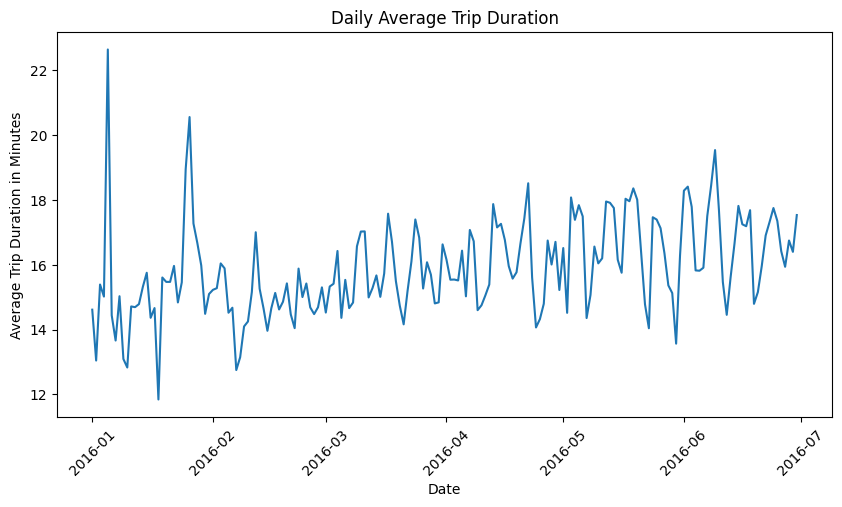

In [11]:
df_train['trip_duration_minute'] =  df_train['trip_duration'] / 60
group = df_train.groupby(df_train['pickup_datetime'].dt.date)['trip_duration_minute'].mean()
plt.figure(figsize=(10,5))
plt.plot(group.index, group.values)   # index = dates, values = mean trip duration
plt.xlabel('Date')
plt.ylabel('Average Trip Duration in Minutes')
plt.title('Daily Average Trip Duration')
plt.xticks(rotation=45)
plt.show()


positive correlation between month and out target feature

In [12]:
# We don't need year column since it's one value 2016

df_train['pickup_month'] = df_train['pickup_datetime'].dt.month

df_train['pickup_day'] = df_train['pickup_datetime'].dt.day

df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour



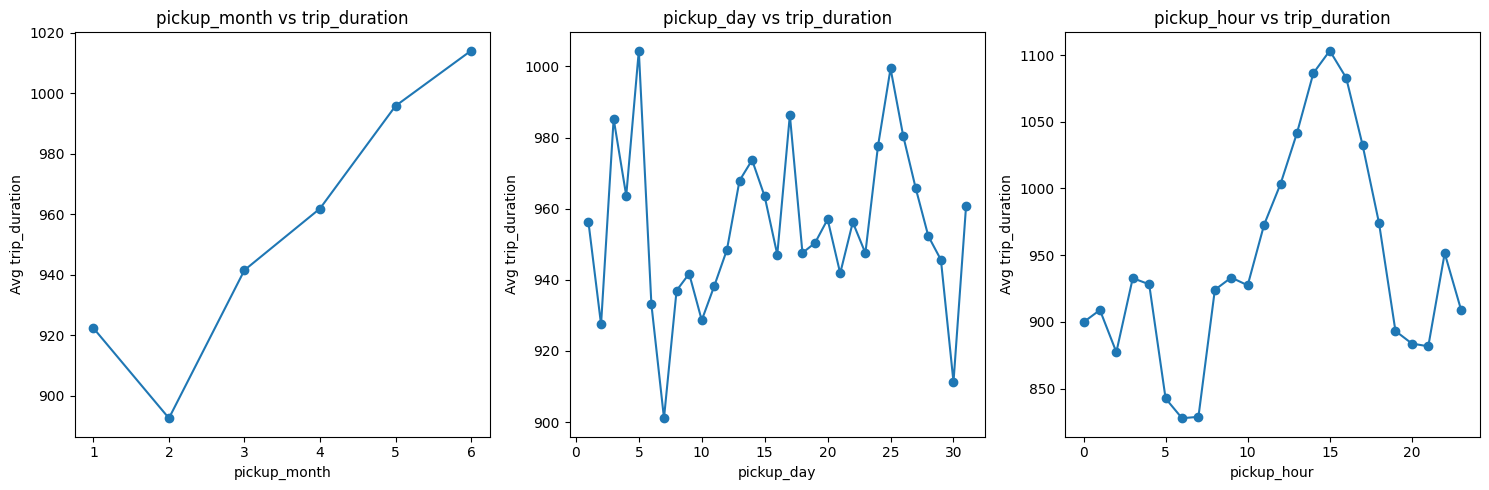

In [13]:

features = ['pickup_month', 'pickup_day', 'pickup_hour']
df_train['trip_duration'] = df_train['trip_duration']
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    
    # Group by feature and take mean of trip_duration
    grouped = df_train.groupby(feature)['trip_duration'].mean()
    
    plt.plot(grouped.index, grouped.values, marker='o')
    plt.xlabel(feature)
    plt.ylabel("Avg trip_duration")
    plt.title(f"{feature} vs trip_duration")

plt.tight_layout()
plt.show()


we see that the trip duration withing 11 to 18 hours are high due to jam since it's the time of work and return from it

we see positive correlation between months and trip duration except month 1


In [14]:
df_train['pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train['is_weekend'] = df_train['pickup_weekday'].isin([5,6]).astype(int) # saturday and sunday
df_train['rush_hour'] = df_train['pickup_hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

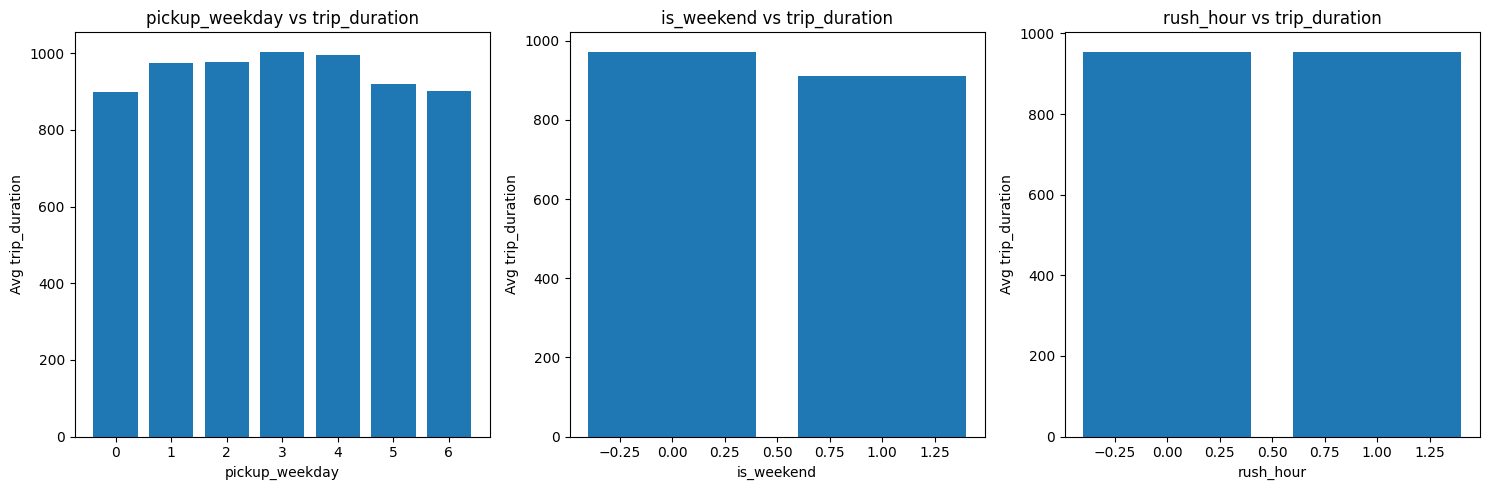

In [15]:
features = ['pickup_weekday', 'is_weekend', 'rush_hour']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    
    # Group by feature and take mean of trip_duration
    grouped = df_train.groupby(feature)['trip_duration'].mean()
    
    plt.bar(grouped.index, grouped.values)
    plt.xlabel(feature)
    plt.ylabel("Avg trip_duration")
    plt.title(f"{feature} vs trip_duration")

plt.tight_layout()
plt.show()


<pre>
    in weekend the traffic is quiet
    we see monday is the quitiest day while thursday and friday the busiest
</pre>

### Explore Latitude and Longitude

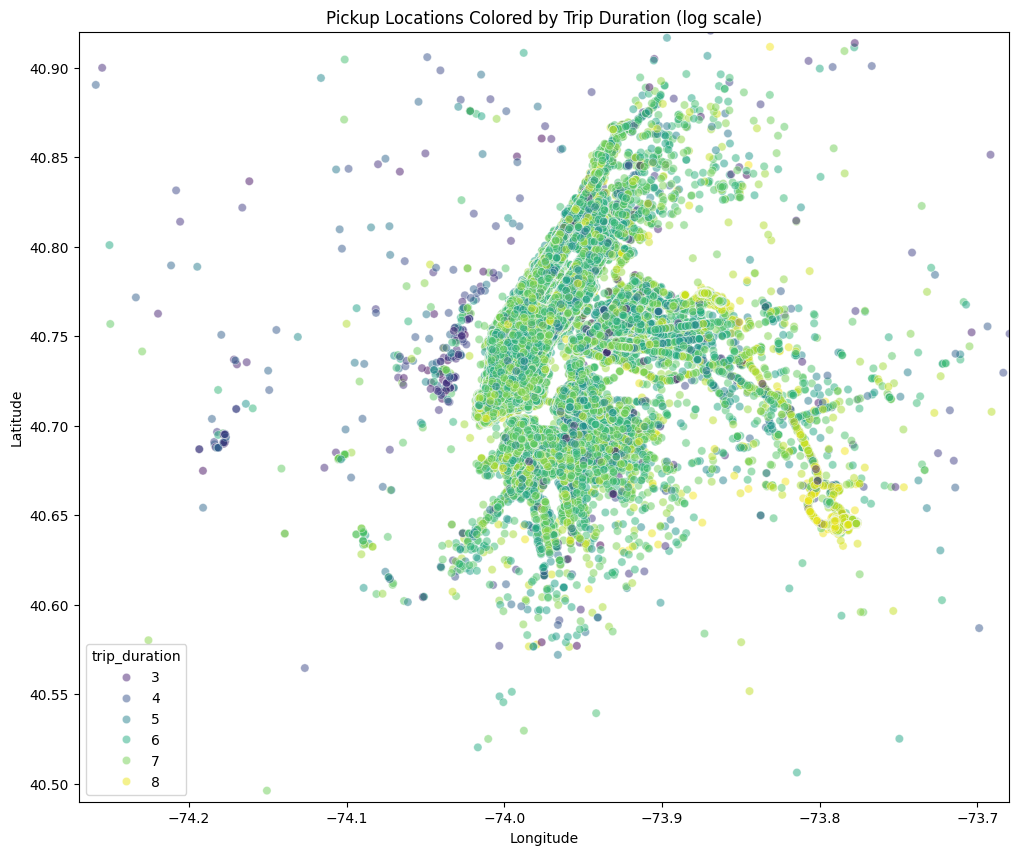

In [16]:
# Filter out extreme outliers
mask = (df_train['trip_duration'] <= 3600) & (df_train['trip_duration'] > 10)
filtered = df_train[mask]

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=filtered,
    x='pickup_longitude',
    y='pickup_latitude',
    hue=np.log1p(filtered['trip_duration']),  # log scale for color
    palette='viridis',
    alpha=0.5,
    legend=True
)
plt.title('Pickup Locations Colored by Trip Duration (log scale)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.27, -73.68)
plt.ylim(40.49, 40.92)
plt.show()

<pre>
the yellow points represent high trip duration , which appear in bottom right, the JFK International Airport ,
 since the trip usually travel to outer place  
</pre>

Eucludien distance

In [17]:
# first we get the Eucludien distance
df_train["latitude_distance"]  = df_train["dropoff_latitude"]  -  df_train["pickup_latitude"]
df_train["longitude_distance"] = df_train["dropoff_longitude"] - df_train["pickup_longitude"]

df_val["latitude_distance"]  = df_val["dropoff_latitude"]  - df_val["pickup_latitude"]
df_val["longitude_distance"] = df_val["dropoff_longitude"] - df_val["pickup_longitude"]

df_train['euclidien_distance'] = np.sqrt(df_train["latitude_distance"]**2 + df_train["longitude_distance"]**2)
df_val['euclidien_distance'] = np.sqrt(df_val["latitude_distance"]**2 + df_val["longitude_distance"]**2)



Haversine Distances

In [18]:
def haversine(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth radius in km



In [19]:
# Apply on both train and val
df_train['haversine_distance'] = haversine(
    df_train['pickup_latitude'].values,
    df_train['pickup_longitude'].values,
    df_train['dropoff_latitude'].values,
    df_train['dropoff_longitude'].values
)

df_val['haversine_distance'] = haversine(
    df_val['pickup_latitude'].values,
    df_val['pickup_longitude'].values,
    df_val['dropoff_latitude'].values,
    df_val['dropoff_longitude'].values
)

Bearing( Direction )

In [20]:
# this function compute the direction of the trip from 0 : 360
def compute_bearing(lat1,lon1,lat2,lon2):
    dlon = np.radians(lon2 - lon1)
    
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    
    # this compute the east-west component
    x = np.sin(dlon) * np.cos(lat2)

    # this compute the North-South component
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    # arctan compute the angle between x and y in radians 
    # np.degrees converts to degrees
    # + 360 and % 360 to make the angle within in range [0:360]
    return (np.degrees(np.arctan2(x, y)) + 360) % 360
    

In [21]:
df_train['bearing'] = compute_bearing(df_train["pickup_latitude"],df_train["pickup_longitude"],df_train["dropoff_latitude"],df_train["dropoff_longitude"])
df_val['bearing'] = compute_bearing(df_val["pickup_latitude"],df_val["pickup_longitude"],df_val["dropoff_latitude"],df_val["dropoff_longitude"])


Manhattan Distance

In [22]:
df_train['manhattan_distance'] = np.abs(df_train["latitude_distance"]) + np.abs(df_train["longitude_distance"])
df_val['manhattan_distance'] = np.abs(df_val["latitude_distance"]) + np.abs(df_val["longitude_distance"])

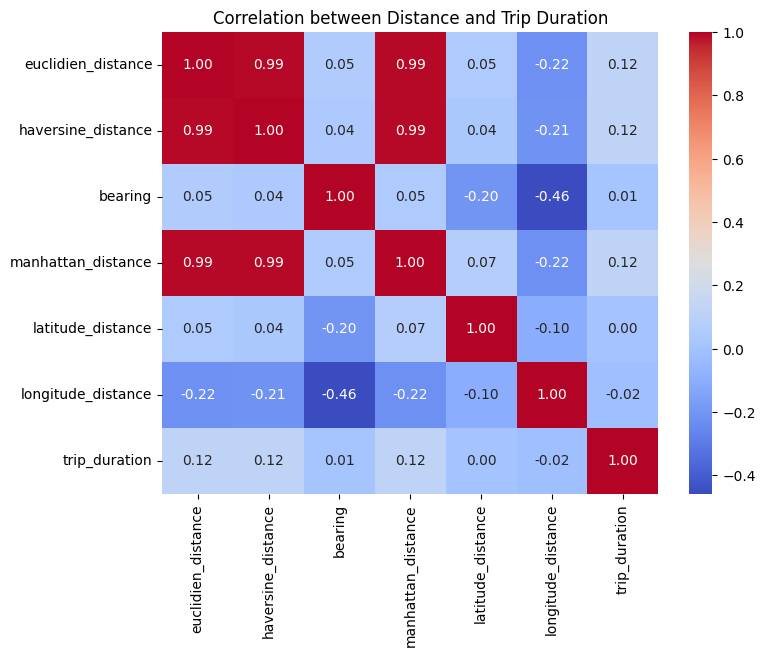

In [23]:
corr = df_train[['euclidien_distance','haversine_distance','bearing','manhattan_distance',"latitude_distance" ,"longitude_distance",'trip_duration']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Distance and Trip Duration")

plt.show()

<pre>
    we see that there is a little correlation between distances and trip duration this might be due to outliers 
    let's see the effect if we delete them
</pre>

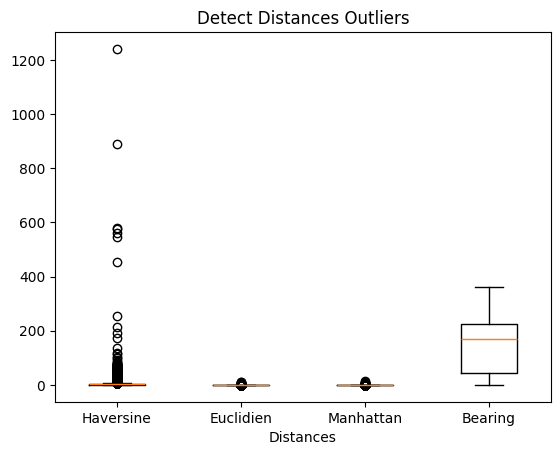

In [24]:
plt.boxplot([df_train['haversine_distance'],df_train['euclidien_distance'],df_train['manhattan_distance'],df_train['bearing']])
plt.xlabel('Distances')
plt.xticks([1,2,3,4],['Haversine','Euclidien','Manhattan','Bearing'])
plt.title('Detect Distances Outliers')
plt.show()

In [25]:
filtered_df = df_train.copy()
Q1 = filtered_df['trip_duration'].quantile(0.25)
Q3 = filtered_df['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
filtered_df = filtered_df[(filtered_df['trip_duration'] >= lower ) & (filtered_df['trip_duration'] <= upper )] 


In [26]:
print(f'upper bound is {upper} and lower bound is {lower}')
filtered_df.shape

upper bound is 2089.5 and lower bound is -618.5


(949061, 23)

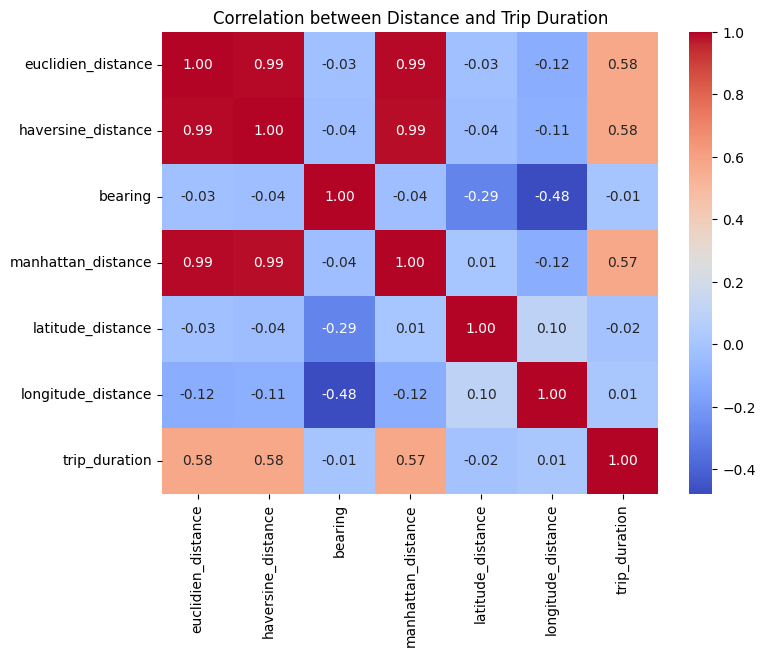

In [27]:
corr = filtered_df[['euclidien_distance','haversine_distance','bearing','manhattan_distance',"latitude_distance" ,"longitude_distance",'trip_duration']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Distance and Trip Duration")

plt.show()

<pre>Now we see that the values change </pre>

that is fine correlation between distances and trip duartion

we see that the haversine distance is the best one


In [28]:
df_train = filtered_df.copy()

### Cluster

In [29]:
from sklearn.cluster import MiniBatchKMeans
# Stack all pickup and dropoff coordinates from train and val sets
coords = np.vstack((
    df_train[['pickup_latitude', 'pickup_longitude']].values,
    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
    df_val[['pickup_latitude', 'pickup_longitude']].values,
    df_val[['dropoff_latitude', 'dropoff_longitude']].values
))

kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000, random_state=42).fit(coords)

# Predict clusters
df_train['pickup_cluster']  = kmeans.predict(df_train[['pickup_latitude','pickup_longitude']].values)
df_train['dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude','dropoff_longitude']].values)


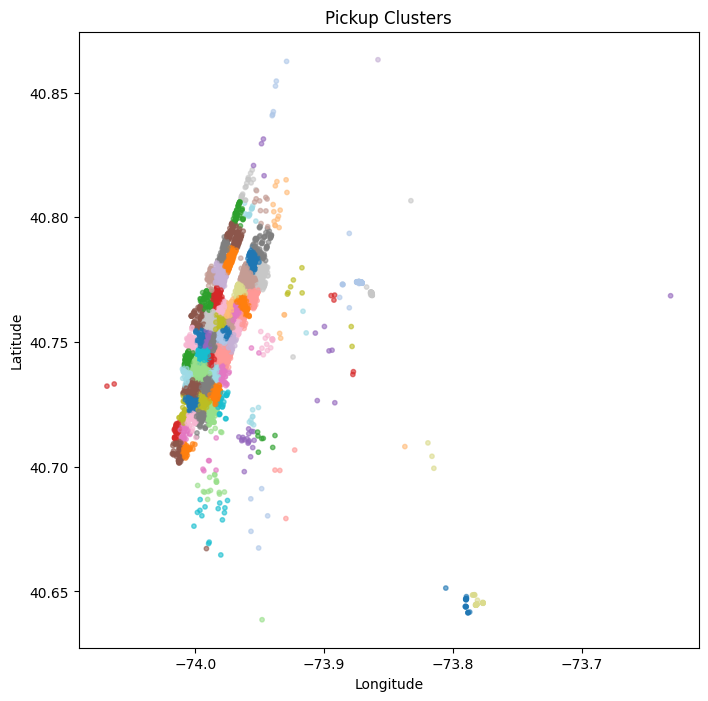

In [31]:

sample = df_train.sample(5000, random_state=42)

plt.figure(figsize=(8,8))
plt.scatter(sample['pickup_longitude'], sample['pickup_latitude'],
            c=sample['pickup_cluster'], cmap='tab20', s=10, alpha=0.6)
plt.title('Pickup Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### Explore Categorical Features

### Passenger Count

In [32]:
print(df_train['passenger_count'].unique())

[1 5 2 3 6 4 0 7]


In [33]:
df_train['passenger_count'].value_counts()

passenger_count
1    674641
2    135148
5     50690
3     38728
6     31541
4     18274
0        37
7         2
Name: count, dtype: int64

the maximum count should be 4,what about 5,6,7 , maybe it differs depending on the taxi provider

0 is incorrect value

In [34]:
print('vendor_id 1',df_train[df_train['vendor_id'] == 1]['passenger_count'].value_counts())
print('vendor_id 2',df_train[df_train['vendor_id'] == 2]['passenger_count'].value_counts())

vendor_id 1 passenger_count
1    361643
2     58598
3     14686
4      7568
5       223
6        99
0        21
Name: count, dtype: int64
vendor_id 2 passenger_count
1    312998
2     76550
5     50467
6     31442
3     24042
4     10706
0        16
7         2
Name: count, dtype: int64


every vendor id has the same passenger count, so it doesn't depend on it

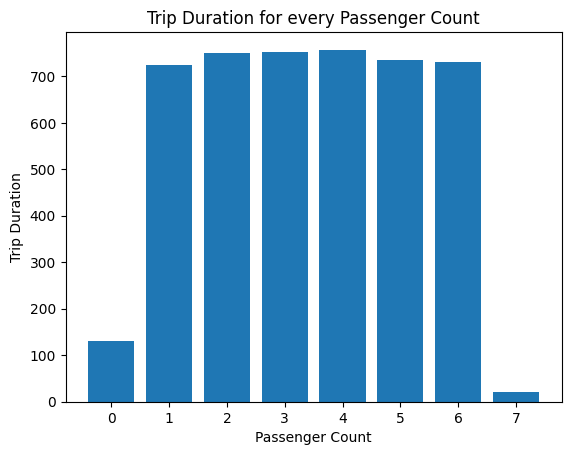

In [35]:
group = df_train.groupby(df_train['passenger_count'])['trip_duration'].mean()
plt.bar(group.index,group.values)
plt.xlabel('Passenger Count')
plt.ylabel('Trip Duration')
plt.title('Trip Duration for every Passenger Count')
plt.show()

positive correlation between passenger count and trip duration(when the number of passenger increase , the trip duration increase) exept at 7 which is incorrect value , we will delete it later

### store and fwd flag

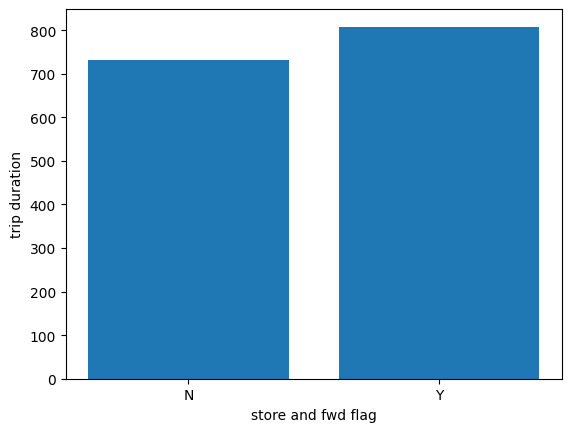

In [36]:
group = df_train.groupby(df_train['store_and_fwd_flag'])['trip_duration'].mean()
plt.bar(group.index,group.values)
plt.xlabel('store and fwd flag')
plt.ylabel('trip duration')
plt.show()

the trips stored in the vechicle memory take along time than the other

### vendor id

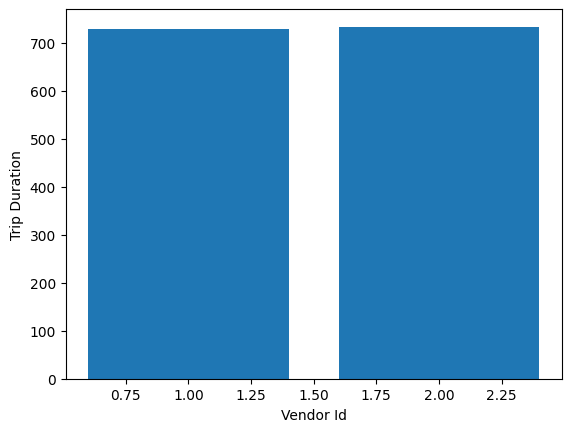

In [37]:
group = df_train.groupby(df_train['vendor_id'])['trip_duration'].mean()
plt.bar(group.index,group.values)
plt.xlabel('Vendor Id')
plt.ylabel('Trip Duration')
plt.show()

class 1,2 of vendor id take equal durations 

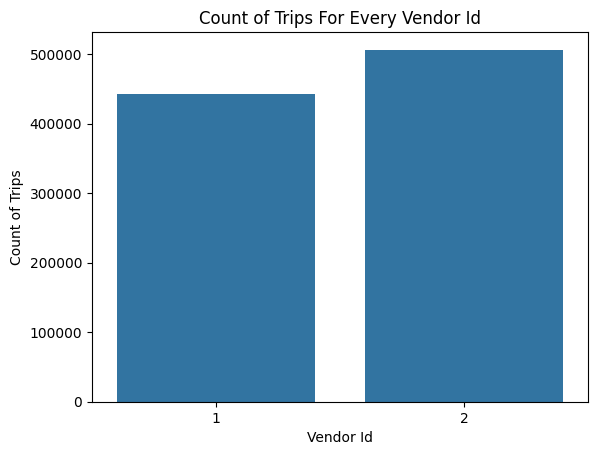

In [38]:
sns.countplot(x='vendor_id', data=df_train)
plt.xlabel('Vendor Id')
plt.ylabel('Count of Trips')
plt.title('Count of Trips For Every Vendor Id')
plt.show()

class 2 of vendor id has more trips than class 1

## Weather Data

### Content:
Weather data collected from the National Weather Service. It contains the first six months of 2016, for a weather station in central park. It contains for each day the minimum temperature, maximum temperature, average temperature, precipitation, new snow fall, and current snow depth. The temperature is measured in Fahrenheit and the depth is measured in inches. T means that there is a trace of precipitation.

In [39]:
weather_df = pd.read_csv('weather data\weather_data_nyc_centralpark_2016(1).csv')

In [40]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 366 non-null    object 
 1   maximum temperature  366 non-null    int64  
 2   minimum temperature  366 non-null    int64  
 3   average temperature  366 non-null    float64
 4   precipitation        366 non-null    object 
 5   snow fall            366 non-null    object 
 6   snow depth           366 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


In [41]:
weather_df.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [42]:
weather_df['date'] = pd.to_datetime(weather_df['date'],format='%d-%m-%Y').dt.date

In [43]:
weather_df['precipitation'].value_counts()

precipitation
0       116
0.00    110
T        24
0.01     12
0.02      6
       ... 
1.41      1
1.81      1
2.2       1
0.19      1
0.39      1
Name: count, Length: 63, dtype: int64

In [44]:
#T means that there is a trace of precipitation.
weather_df['precipitation'] = weather_df['precipitation'].replace('T',0.001)
weather_df['precipitation'] = weather_df['precipitation'].astype(float)

In [45]:
weather_df['snow fall'].value_counts()

snow fall
0       179
0.0     162
T        15
0.4       3
0.2       1
2.5       1
27.3      1
0.1       1
1.4       1
0.5       1
2.8       1
Name: count, dtype: int64

In [46]:
weather_df['snow depth'].value_counts()

snow depth
0     346
T       7
6       4
1       2
2       2
22      1
17      1
19      1
4       1
9       1
Name: count, dtype: int64

In [47]:
df_train['pickup_date_only'] = df_train['pickup_datetime'].dt.date
df_train = df_train.merge(
    weather_df,
    left_on='pickup_date_only',
    right_on='date',
    how='left'
)

In [48]:
print((df_train['date'] == df_train['pickup_date_only']))

0         True
1         True
2         True
3         True
4         True
          ... 
949056    True
949057    True
949058    True
949059    True
949060    True
Length: 949061, dtype: bool


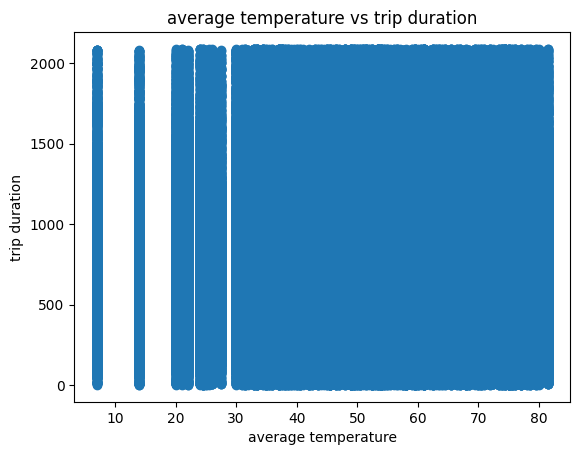

In [49]:
plt.scatter(df_train['average temperature'],df_train['trip_duration'])
plt.xlabel('average temperature')
plt.ylabel('trip duration')
plt.title('average temperature vs trip duration')
plt.show()

In [50]:
print('Correlation between trip duration and average temprature',df_train['trip_duration'].corr(df_train['average temperature']))

Correlation between trip duration and average temprature 0.03794143107537411


No relation between trip_duration and average temperature

In [51]:
print('Correlation between trip duration and max temprature',df_train['trip_duration'].corr(df_train['maximum temperature']))
print('Correlation between trip duration and min temprature',df_train['trip_duration'].corr(df_train['minimum temperature']))

Correlation between trip duration and max temprature 0.03635855706698712
Correlation between trip duration and min temprature 0.03864995532145079


No relation between trip_duration and max&min temperature

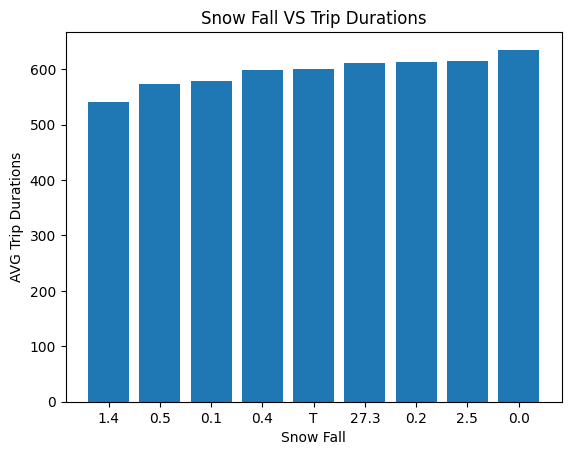

In [52]:
plt.Figure(figsize=(12,8))
groub = df_train.groupby('snow fall')['trip_duration'].median().sort_values()
plt.bar(groub.index,groub.values)
plt.xlabel('Snow Fall')
plt.ylabel('AVG Trip Durations')
plt.title('Snow Fall VS Trip Durations')
plt.show()

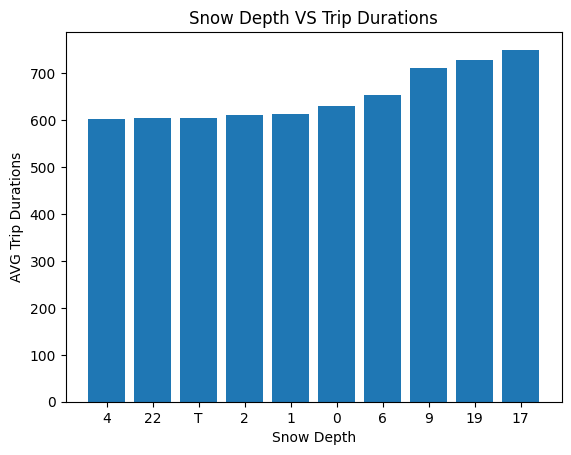

In [53]:
plt.Figure(figsize=(12,8))
groub = df_train.groupby('snow depth')['trip_duration'].median().sort_values()
plt.bar(groub.index,groub.values)
plt.xlabel('Snow Depth')
plt.ylabel('AVG Trip Durations')
plt.title('Snow Depth VS Trip Durations')
plt.show()

No relation between Snow and Trip Duration , maybe because the people tend to take short trips when it is snowing

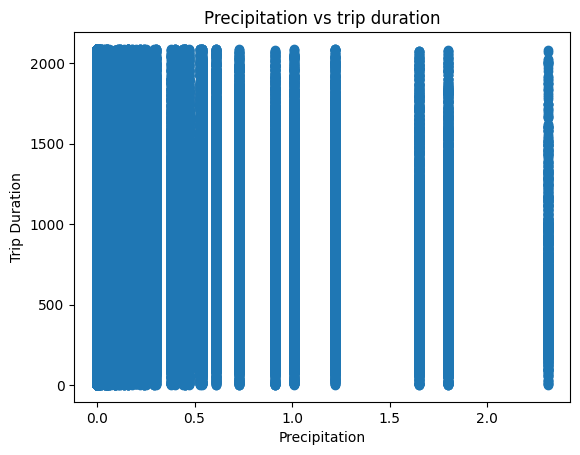

Correlation between trip duration and Precipitation 0.03881342865198582


In [54]:
plt.scatter(df_train['precipitation'],df_train['trip_duration'])
plt.xlabel('Precipitation')
plt.ylabel('Trip Duration')
plt.title('Precipitation vs trip duration')
plt.show()
print('Correlation between trip duration and Precipitation',df_train['precipitation'].corr(df_train['minimum temperature']))

no relation between precipitation and Trip Duration

## Correlation Matrix

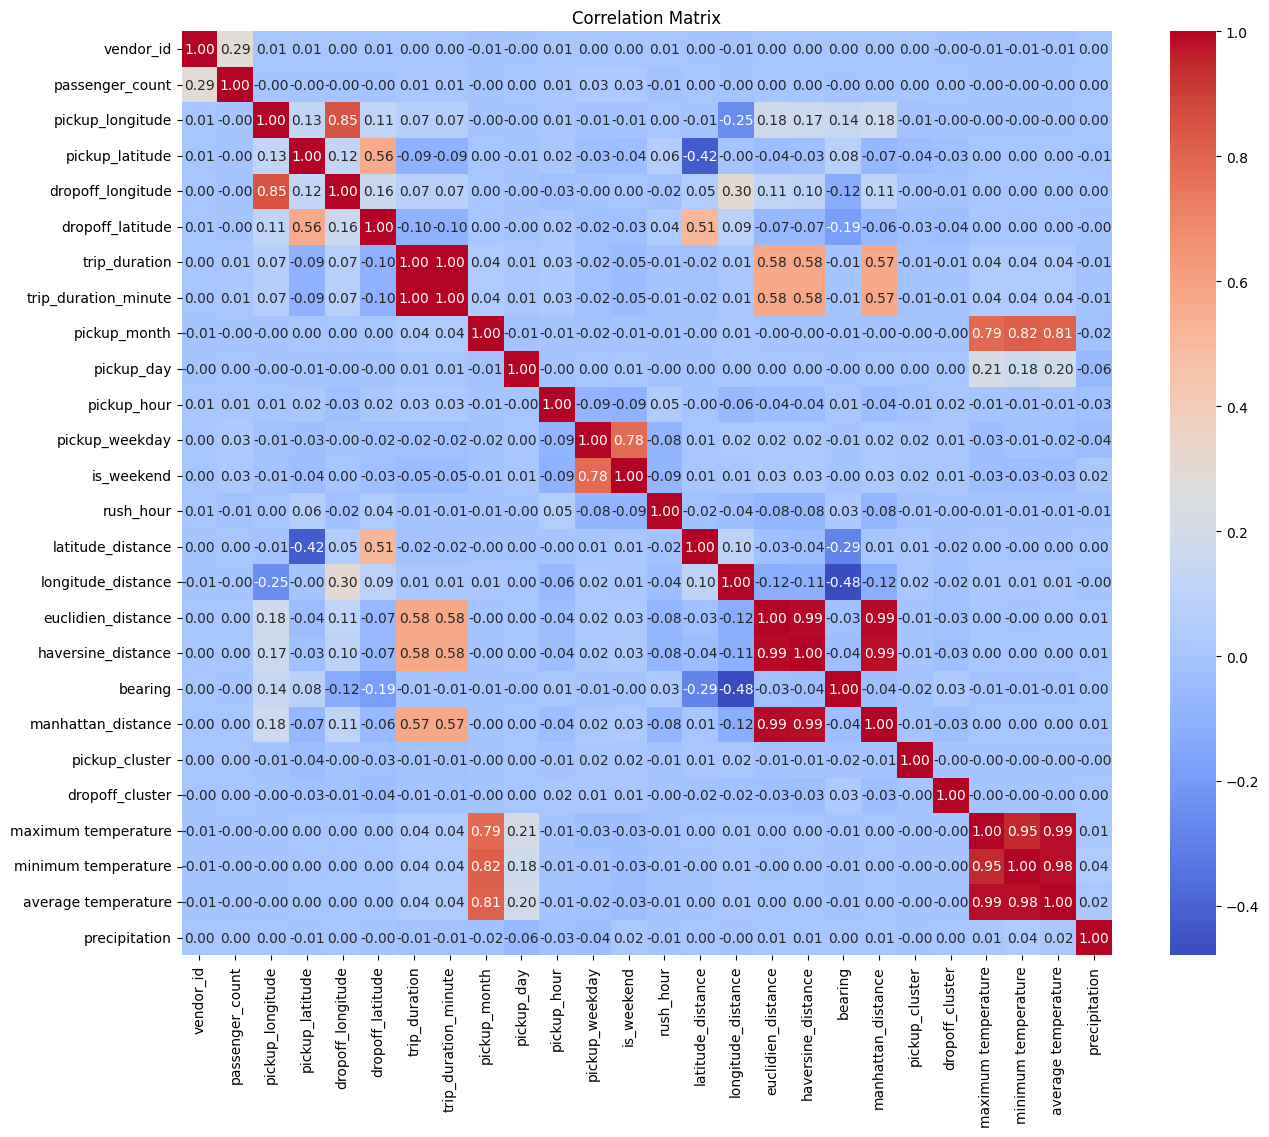

In [55]:
corr = df_train.select_dtypes('number').corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Feature Selection

In [56]:
print(df_train.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'trip_duration_minute', 'pickup_month', 'pickup_day', 'pickup_hour',
       'pickup_weekday', 'is_weekend', 'rush_hour', 'latitude_distance',
       'longitude_distance', 'euclidien_distance', 'haversine_distance',
       'bearing', 'manhattan_distance', 'pickup_cluster', 'dropoff_cluster',
       'pickup_date_only', 'date', 'maximum temperature',
       'minimum temperature', 'average temperature', 'precipitation',
       'snow fall', 'snow depth'],
      dtype='object')


In [57]:
df_train['store_and_fwd_flag'] = df_train['store_and_fwd_flag'].replace({'Y':1,'N':0})
df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'])
df_train['snow fall'] = df_train['snow fall'].replace('T',0.0).astype(float)
df_train['snow depth'] = df_train['snow depth'].replace('T',0.0).astype(float)
cols = ['vendor_id', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude','store_and_fwd_flag','pickup_month', 'pickup_day', 'pickup_hour',
       'pickup_weekday', 'is_weekend', 'rush_hour', 'latitude_distance',
       'longitude_distance', 'euclidien_distance', 'haversine_distance',
       'bearing', 'manhattan_distance', 'pickup_cluster', 'dropoff_cluster','maximum temperature',
       'minimum temperature', 'average temperature', 'precipitation',
       'snow fall', 'snow depth']
X = df_train[cols]
y = df_train['log_trip_duration']

In [58]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.001)
model.fit(X,y)
coef = model.coef_
feature_weights = pd.DataFrame({
    'Feature':X.columns,
    'Weights':coef
}).sort_values(by='Weights',key=abs,ascending=False)
print(feature_weights)

                Feature   Weights
14   longitude_distance  1.267863
3       pickup_latitude -0.601021
2      pickup_longitude -0.250916
11           is_weekend -0.119264
16   haversine_distance  0.106963
12            rush_hour  0.044766
7          pickup_month  0.015333
10       pickup_weekday  0.011552
26           snow depth  0.009311
24        precipitation -0.007962
1       passenger_count  0.007655
9           pickup_hour  0.005868
0             vendor_id  0.001643
22  minimum temperature  0.000474
25            snow fall  0.000428
17              bearing  0.000398
21  maximum temperature -0.000190
20      dropoff_cluster  0.000168
19       pickup_cluster -0.000166
8            pickup_day  0.000074
5      dropoff_latitude -0.000000
6    store_and_fwd_flag -0.000000
4     dropoff_longitude  0.000000
18   manhattan_distance  0.000000
15   euclidien_distance  0.000000
13    latitude_distance  0.000000
23  average temperature  0.000000


In [59]:
df_train['snow_fall_label'] = df_train['snow fall'].apply(lambda x: 0 if x == 0 else 1 )
df_train['snow_depth_label'] = df_train['snow depth'].apply(lambda x: 0 if x == 0 else 1)


In [60]:
cols.append('snow_fall_label')
cols.append('snow_depth_label')

In [61]:
X = df_train[cols]
model = Lasso(alpha=0.001)
model.fit(X,y)
coef = model.coef_
feature_weights = pd.DataFrame({
    'Feature':X.columns,
    'Weights':coef
}).sort_values(by='Weights',key=abs,ascending=False)
print(feature_weights)

                Feature   Weights
14   longitude_distance  1.268025
3       pickup_latitude -0.601265
2      pickup_longitude -0.250766
11           is_weekend -0.120227
16   haversine_distance  0.106966
12            rush_hour  0.044771
27      snow_fall_label -0.020128
7          pickup_month  0.015379
10       pickup_weekday  0.011645
26           snow depth  0.009190
1       passenger_count  0.007657
24        precipitation -0.007393
9           pickup_hour  0.005869
25            snow fall  0.001675
0             vendor_id  0.001641
22  minimum temperature  0.000440
17              bearing  0.000398
21  maximum temperature -0.000219
20      dropoff_cluster  0.000168
19       pickup_cluster -0.000166
8            pickup_day  0.000078
6    store_and_fwd_flag -0.000000
5      dropoff_latitude -0.000000
4     dropoff_longitude  0.000000
13    latitude_distance  0.000000
18   manhattan_distance  0.000000
15   euclidien_distance  0.000000
23  average temperature  0.000000
28     snow_de